In [47]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import matplotlib.pyplot as plt

import mne
mne.set_log_level(False)

from sklearn.preprocessing import minmax_scale

import pandas as pd
import numpy as np
import pickle
import seaborn as sns
from glob import glob
from collections import Counter
from os import listdir

from mpl_toolkits.axes_grid1 import make_axes_locatable

sourceloc = "../sempred/" # location of saved epochs
out_template = sourceloc + "{0}-{1}-{2}.fif"

savs = sourceloc+"results/"

In [ ]:
# Depending on processing power, this script can take anywhere from 8-24 hours to complete - not including cross
# decoding.

In [48]:
bad_subjs = {"ANA11","SKK20","GMA05", "PBT16","HHA01","BSN17","AHA31", "KHA01", "KKA17","RAC22","VLA21"}
subjsC = [file.split("-")[0] for file in listdir(sourceloc) 
                            if file.split("-")[0] not in bad_subjs and "aw" in file]
len(subjsC)

35

In [49]:
bad_subjsA = {"AJA28", "EKI28", "PAA15", "RRK21", "SPN30", "UDE20","HFE14","SON11","CMA02"}
subjsA = {file.split("-")[0] for file in listdir(sourceloc) 
                                              if "anim" in file and file.split("-")[0] not in bad_subjsA} 
len(subjsA)

35

In [50]:
def get_epoch(name, exp):
    '''load epochs'''
    epoch = mne.read_epochs(out_template.format(name,exp, "epo")).crop(tmax=1.)
    return (epoch if exp=="anim" else epoch.drop_channels(["SO1","SO2"]))

times = get_epoch(subjsC[0], "aw").times # get time points

# Time Generalization Decoding Pipeline and Threshold Free Cluster Enhancement


In [52]:
from mne.decoding import SlidingEstimator, cross_val_multiscore, Scaler, Vectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import SVC
from mne.decoding import GeneralizingEstimator
from sklearn.model_selection import StratifiedKFold

clf = make_pipeline(StandardScaler(), SVC(kernel="linear", class_weight="balanced"))
sl = SlidingEstimator(clf, scoring="roc_auc")
gen_clf = GeneralizingEstimator(clf)

### Decoding abstract vs. concrete

In [54]:
the_names = ["aud", "vis", "pauses"]
all_res = dict()
for subj in subjsC:
    print(subj, end=", ")
    all_res[subj] = res = dict()
    epochs_pauses, epochs_aud, epochs_vis = get_epoch(subj, "abst_cct"), get_epoch(subj, "aw"), get_epoch(subj, "vw")
    epochs_pauses.metadata["typ"] += 1
    the_epochs = [epochs_aud, epochs_vis, epochs_pauses]
    for name1, epochs1 in zip(the_names, the_epochs):
        print(name1, end=", ")
        if name1 not in res:
            res[(name1)] = cross_val_multiscore(gen_clf,epochs1.get_data(),epochs1.metadata["typ"],cv=5, 
                                                n_jobs=5).mean(0)

all_res_cct = {name1: list() for name1 in the_names}
for subj in subjsC:
    for cond1 in the_names:
        all_res_cct[cond1].append(all_res[subj][cond1])

BHT21, aud, vis, pauses, BJA19, aud, vis, pauses, BPE14, aud, vis, pauses, BRE14, aud, vis, pauses, CEH02, aud, vis, pauses, CFA01, aud, vis, pauses, CFR02, aud, vis, pauses, CNA20, aud, vis, pauses, CTE21, aud, vis, pauses, CWE20, aud, vis, pauses, DEA08, aud, vis, pauses, DKT18, aud, vis, pauses, DTA06, aud, vis, pauses, ECA21, aud, vis, pauses, EHN21, aud, vis, pauses, EMA29, aud, vis, pauses, ETN07, aud, vis, pauses, HBA27, aud, vis, pauses, KGL18, aud, vis, pauses, pauses, LPE09, aud, vis, pauses, MCA16, aud, vis, pauses, MHA28, aud, vis, pauses, MPE24, aud, vis, pauses, MSN05, aud, vis, pauses, MSN20, aud, vis, pauses, RFA13, aud, vis, pauses, SAL12, aud, vis, pauses, SMA17, aud, vis, pauses, SSA20, aud, vis, pauses, SWA02, aud, vis, pauses, SWA10, aud, vis, pauses, UHA03, aud, vis, pauses, VAT16, aud, vis, pauses, YTA24, aud, vis, pauses, 

In [58]:
tfce_res_cct = dict()

In [60]:
the_names = ["aud", "vis", "pauses"]
threshold_tfce = dict(start=0.1, step=0.2)
for name1 in the_names:
    data = np.array(all_res_cct[(name1)])[:, 60:, 60:] # only run TFCE on 0 - 1000 ms
    if (name1) not in tfce_res_cct:
        tfce_res_cct[(name1)] = mne.stats.spatio_temporal_cluster_1samp_test(
            data - .5, threshold=threshold_tfce,
            n_permutations=1024, tail=0,
            stat_fun=None, connectivity=None, verbose=None, n_jobs=5, seed=None,
            max_step=1, step_down_p=0, t_power=1, out_type='mask',
            check_disjoint=False, buffer_size=1000)

### Decoding animate vs. inanimate

In [ ]:
# Decoding for animate/inanimate delayed words
the_names = ["pauses",]
all_res_1 = dict()
for subj in subjsA:
    print(subj, end=", ")
    all_res_1[subj] = res = dict()
    epochs_pauses = get_epoch(subj, "anim")
    the_epochs = [epochs_pauses,]
    for name1, epochs1 in zip(the_names, the_epochs):       
        if name1 not in res:
            res[name1] = cross_val_multiscore(gen_clf,epochs1.get_data(), epochs1.events[:,-1], cv=5, 
                                              n_jobs=5).mean(0)

all_res_anim = {"pauses": []}
for subj in subjsA:
    all_res_anim['pauses'].append(all_res_1[subj]["pauses"])

ULL10, EJA08, GFA21, MSA05, CHA06, SJA11, SLA04, CKE20, GYN22, UBA28, PRA08, HMA05, SGT08, LLA08, MRA28, ISA01, DLA04, GMD30, DMA22, SPN24, MSA19, JSP28, SNN16, HBA18, GSY17, KDA22, BBA33, MDA02, GSU02, EKK13, IJE19, MSS28, DPA23, GME03, 

In [66]:
tfce_res_anim = dict()

In [68]:
threshold_tfce = dict(start=0.1, step=0.2)
the_names = "pauses"

data = np.array(all_res_anim[the_names])[:, 60:, 60:] # only run TFCE on 0 - 1000 ms
if the_names not in tfce_res_anim:
    tfce_res_anim[(the_names)] = mne.stats.spatio_temporal_cluster_1samp_test(
        data - .5, threshold=threshold_tfce,
        n_permutations=1024, tail=0,
        stat_fun=None, connectivity=None, verbose=None, n_jobs=5, seed=None,
        max_step=1, step_down_p=0, t_power=1, out_type='mask',
        check_disjoint=False, buffer_size=1000)



# Plot Results

In [69]:
def plot_image(data, times, mask=None, ax=None, vmax=None, vmin=None,
               draw_mask=None, draw_contour=None, colorbar=True,
               draw_diag=True, draw_zerolines=True, xlabel="Time (s)", ylabel="Time (s)",
               cbar_unit="%", cmap="RdBu_r", mask_alpha=.5, mask_cmap="RdBu_r"):
    """Return fig and ax for further styling, e.g., titles"""
    if ax is None:
        fig = plt.figure()
        ax = plt.axes()

    if vmax is None:
        vmax = np.abs(data).max()
    if vmin is None:
        vmax = np.abs(data).max()
        vmin = -vmax
    tmin, tmax = xlim = times[0], times[-1]
    extent = [tmin, tmax, tmin, tmax]
    im_args = dict(interpolation='nearest', origin='lower',
                   extent=extent, aspect='auto', vmin=vmin, vmax=vmax)

    if mask is not None:
        draw_mask = True if draw_mask is None else draw_mask
        draw_contour = True if draw_contour is None else draw_contour
    if any((draw_mask, draw_contour,)):
        if mask is None:
            raise ValueError("No mask to show!")

    if draw_mask:
        ax.imshow(data, alpha=mask_alpha, cmap=mask_cmap, **im_args)
        im = ax.imshow(np.ma.masked_where(~mask, data), cmap=cmap, **im_args)
    else:
        im = ax.imshow(data, cmap=cmap, **im_args)
    if draw_contour and np.unique(mask).size == 2:
        big_mask = np.kron(mask, np.ones((10, 10)))
        ax.contour(big_mask, colors=["k"], extent=extent, linewidths=[1.3],
                   aspect=1,
                   corner_mask=False, antialiased=False, levels=[.5])
    ax.set_xlim(xlim)
    ax.set_ylim(xlim)

    if draw_diag:
        ax.plot((tmin, tmax), (tmin, tmax), color="k", linestyle=":")
    if draw_zerolines:
        ax.axhline(0, color="k", linestyle=":")    
        ax.axvline(0, color="k", linestyle=":")


    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)

    if colorbar:
        cbar = plt.colorbar(im, ax=ax, shrink=.65)
        cbar.ax.set_title(cbar_unit)
    ax.set_aspect(1./ax.get_data_ratio())
    #ax.set_title("GAT Matrix")
    
    return (fig if ax is None else ax)

/data/home1/eheikel/tools/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'aspect'
  s)


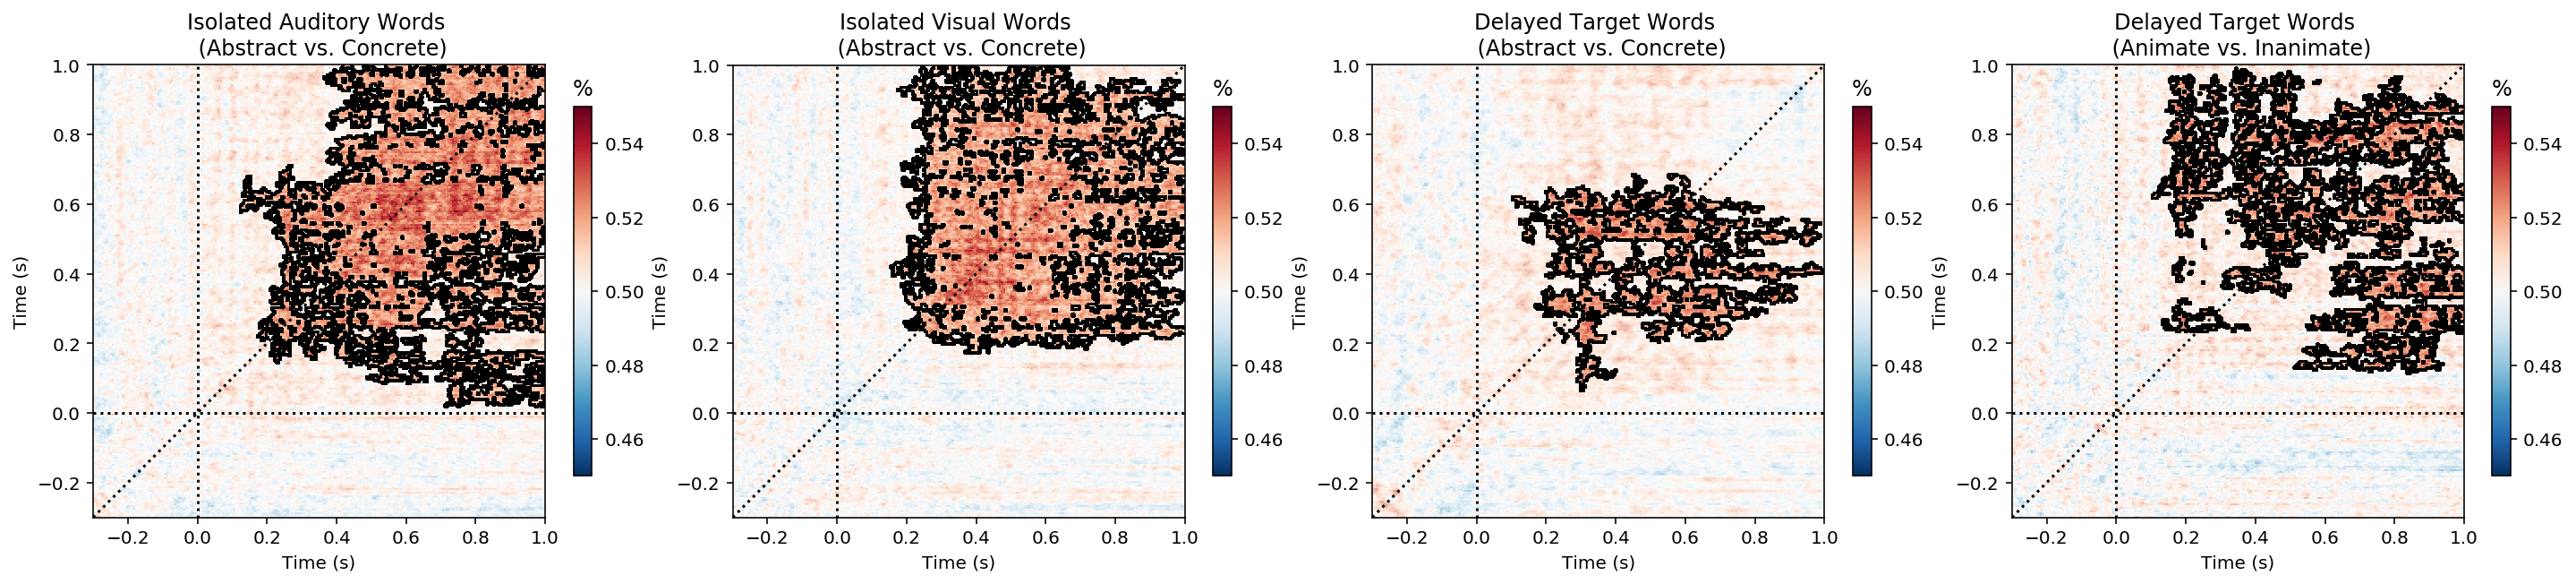

In [70]:
fig, axes = plt.subplots(ncols=4, nrows=1)
fig.set_size_inches((20, 5))
fig.tight_layout()
the_names = ["aud", "vis", "pauses"]
titles = {"aud": "Isolated Auditory Words \n (Abstract vs. Concrete)",
          "vis": "Isolated Visual Words \n (Abstract vs. Concrete)",
          "pauses": "Delayed Target Words \n (Abstract vs. Concrete)",}

# Plot Abstract vs. Concrete Decoding (auditory, visual, delayed target words)
for name1 in all_res_cct.keys():
    ax = axes[the_names.index(name1)]
    ax.set_title(titles[name1])
    data = np.array(all_res_cct[(name1)])[:, :261, :261]
    t, clusters, cluster_pv, h0 = tfce_res_cct[(name1)]
    x = (cluster_pv.reshape(t.shape) < .05) #+ (cluster_pv.reshape(t.shape) < .01)
    d = np.array([[False for x in range(261)] for y in range(261)])
    d[60:, 60:] = x
    df = pd.DataFrame(d, index=times,
                      columns=times).sort_index(ascending=False)        
    im = plot_image(data.mean(0), times, mask=d, ax=ax, vmax=.55, vmin=.45,
           draw_mask=True, draw_contour=True, colorbar=True,# (True if name1=="pauses" else False),
           draw_diag=True, draw_zerolines=True, xlabel="Time (s)", ylabel="Time (s)",
           cbar_unit="%", cmap="RdBu_r", mask_alpha=.5, mask_cmap="RdBu_r");

# Plot Animate vs. Inanimate Decoding of delayed target words
for name1 in all_res_anim.keys():
    ax = axes[-1]
    ax.set_title("Delayed Target Words \n (Animate vs. Inanimate)")
    data = np.array(all_res_anim[(name1)])
    t, clusters, cluster_pv, h0 = tfce_res_anim[(name1)]
    x = (cluster_pv.reshape(t.shape) < .05) #+ (cluster_pv.reshape(t.shape) < .01)
    d = np.array([[False for x in range(261)] for y in range(261)])
    d[60:261, 60:261] = x
    df = pd.DataFrame(d, index=times,
                      columns=times).sort_index(ascending=False)        
    plot_image(data.mean(0), times, mask=d, ax=ax, vmax=.55, vmin=.45,
           draw_mask=True, draw_contour=True, colorbar=True,# (True if name1=="pauses" else False),
           draw_diag=True, draw_zerolines=True, xlabel="Time (s)", ylabel="Time (s)",
           cbar_unit="%", cmap="RdBu_r", mask_alpha=.5, mask_cmap="RdBu_r");  

black = $p < .05$

In [71]:
def start_of_diagonal(name, tfce_res):
    '''Identify earliest and latest performance of significance, along the diagonal in the GAT matrix significant.
    As identified by TFCE'''
    no_res=False
    t, clusters, cluster_pv, h0 = tfce_res[(name)]
    x = (cluster_pv.reshape(t.shape) < .05)
    d = np.array([[False for x in range(261)] for y in range(261)])
    d[60:, 60:] = x
    m = d.diagonal()
    for ii, x in enumerate(m):
        if x:
            start= times[ii]
            break
        if ii==len(m)-1 and not x:
            no_res = True
    for i, x in enumerate(m[::-1]):
        if x:
            end = times[(len(times)-1)-i]
            break

    if no_res:
        return print('No time points of significance over diagonal')
    else:
        return "Significant diagonal decoding starts at {} and ends at {}".format(*[start, end])        

In [72]:
start_of_diagonal("aud", tfce_res_cct)

'Significant diagonal decoding starts at 0.225 and ends at 1.0'

In [73]:
start_of_diagonal("vis", tfce_res_cct)

'Significant diagonal decoding starts at 0.25 and ends at 0.955'

In [74]:
start_of_diagonal("pauses", tfce_res_cct)

'Significant diagonal decoding starts at 0.24 and ends at 0.61'

In [75]:
start_of_diagonal("pauses", tfce_res_anim)

'Significant diagonal decoding starts at 0.235 and ends at 0.88'

# Cross decoding abstract vs. concrete (visual-auditory-pauses)

This part takes a very (very!) long time to run - but an example of the cross decoding pipeline.

In [ ]:
the_names = ["aud", "vis", "pauses"]

gen_clf = GeneralizingEstimator(clf)
all_res = dict()
for subj in subjsC:
    print(subj, end=", ")
    all_res[subj] = res = dicta()
    epochs_pauses, epochs_aud, epochs_vis = get_epoch(subj, "abst_cct"), get_epoch(subj, "aw"), get_epoch(subj, "vw")
    epochs_pauses.metadata["typ"] += 1

    the_epochs = [epochs_aud, epochs_vis, epochs_pauses]
    for name1, epochs1 in zip(the_names, the_epochs): #training
        for name2, epochs2 in zip(the_names, the_epochs): #testing
            print(name1, name2, end=", ")
            if (name1, name2) not in res:
                res[(name1, name2)] = cross_val_multiscore(gen_clf,
                                                               epochs1.get_data(),
                                                               epochs1.metadata["typ"],
                                                               cv=5, n_jobs=5).mean(0)

BHT21, aud aud, aud vis, aud pauses, vis aud, vis vis, vis pauses, pauses aud, pauses vis, pauses pauses, BJA19, aud aud, aud vis, aud pauses, vis aud, vis pauses, pauses aud, pauses vis, pauses pauses, BPE14, aud aud, aud vis, aud pauses, vis aud, vis vis, vis pauses, pauses aud, pauses vis, pauses pauses, BRE14, aud aud, aud vis, aud pauses, vis aud, vis vis, vis pauses, pauses aud, pauses vis, pauses pauses, CEH02, aud aud, aud vis, aud pauses, vis aud, vis vis, vis pauses, pauses aud, pauses vis, pauses pauses, CFA01, aud aud, aud vis, aud pauses, vis aud, vis vis, vis pauses, pauses aud, pauses vis, pauses pauses, CFR02, aud aud, aud vis, aud pauses, vis aud, vis vis, vis pauses, pauses aud, pauses vis, pauses pauses, CNA20, aud aud, aud vis, aud pauses, vis aud, vis vis, vis pauses, pauses aud, pauses vis, pauses pauses, CTE21, aud aud, aud vis, aud pauses, vis aud, vis vis, vis pauses, pauses aud, pauses vis, pauses pauses, CWE20, aud aud, aud vis, aud pauses, vis aud, vis vis, 

In [ ]:
all_res_cct_cross = {(name1, name2): list() for name1 in the_names for name2 in the_names}
for subj in subjsC:
    for cond1 in the_names:
        for cond2 in the_names:
            all_res_cct_cross[(cond1, cond2)].append(all_res[subj][(cond1, cond2)])

In [ ]:
tfce_res_cct_cross = dict()

In [148]:
the_names = ["aud", "vis", "pauses"]
threshold_tfce = dict(start=0.1, step=0.2)

for name1 in the_names:
    for name2 in the_names:
        data = np.array(all_res_cct_cross[(name1, name2)])[:, 60:, 60:]
        if (name1, name2) not in tfce_res_cct_cross:
            tfce_res_cct_cross[(name1, name2)] = mne.stats.spatio_temporal_cluster_1samp_test(
                data - .5, threshold=threshold_tfce,
                n_permutations=1024, tail=0,
                stat_fun=None, connectivity=None, verbose=None, n_jobs=5, seed=None,
                max_step=1, step_down_p=0, t_power=1, out_type='mask',
                check_disjoint=False, buffer_size=1000)

/data/home1/eheikel/tools/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'aspect'
  s)


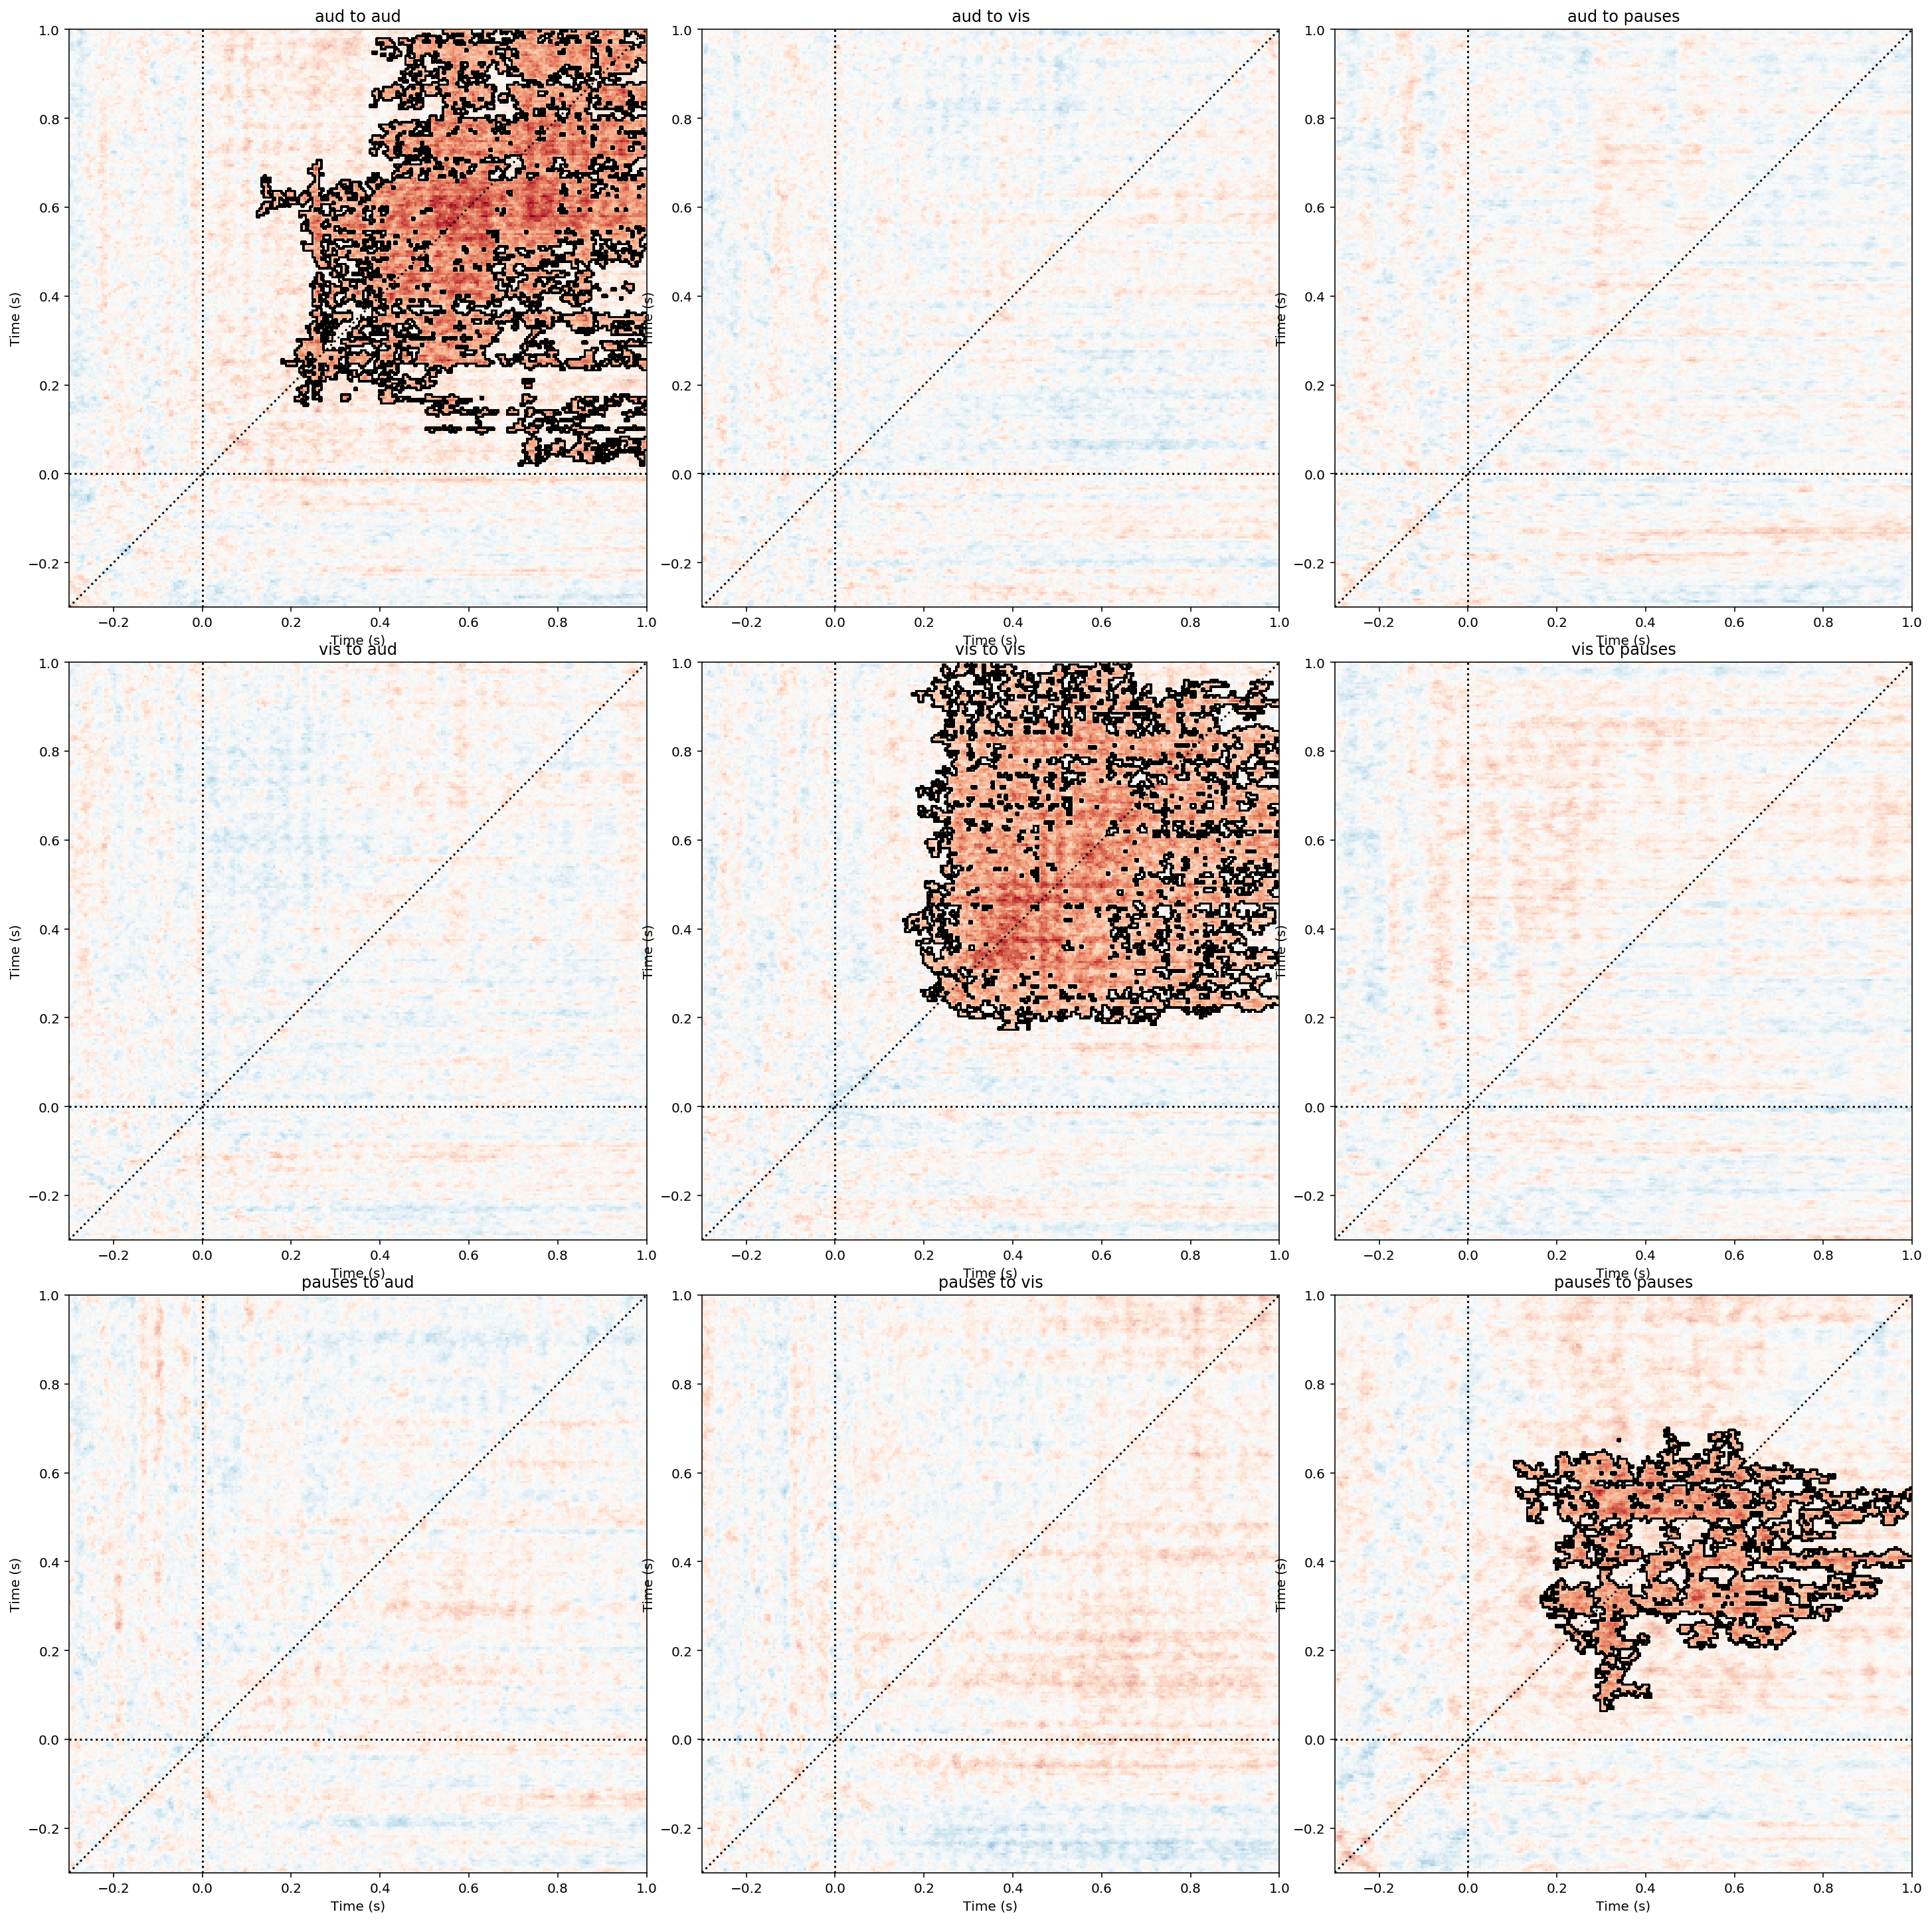

In [155]:
fig, axes = plt.subplots(ncols=3, nrows=3)
fig.set_size_inches((20, 20))
fig.tight_layout()
the_names = ["aud", "vis", "pauses"]

for name1 in the_names:
    for name2 in the_names:
        ax = axes[the_names.index(name1), the_names.index(name2)]
        ax.set_title((name1 + " to " + name2))
        data = np.array(all_res_cct_cross[(name1, name2)])
        t, clusters, cluster_pv, h0 = tfce_res_cct2[(name1, name2)]
        x = (cluster_pv.reshape(t.shape) < .05)
        d = np.array([[False for x in range(261)] for y in range(261)])
        d[60:, 60:] = x
        df = pd.DataFrame(d, index=times,
                          columns=times).sort_index(ascending=False)        
        im = plot_image(data.mean(0), times, mask=d, ax=ax, vmax=.55, vmin=.45,
               draw_mask=True, draw_contour=True, colorbar=False,# (True if name1=="pauses" else False),
               draw_diag=True, draw_zerolines=True, xlabel="Time (s)", ylabel="Time (s)",
               cbar_unit="%", cmap="RdBu_r", mask_alpha=.5, mask_cmap="RdBu_r");

A cross decoding matrix, rows correspond to training and columns testing, example row 1 column 1 corresponds to within auditory isolated words, column 2 trained on isolated words tested on visual words, column 3 tested on delayed target words (0-1000 ms corresponding to the pause of the delayed target word)

Row 2, trained visual isolated words with column 1 testing on isolated auditory words, column 2 tested on visual words, column 3 delayed words.

Row 3, trained on the pause of delayed words. etc

No cross decoding observed.